### Project python Code

In [32]:
#Imports
import pandas as pd
import numpy as np
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd


In [33]:

df=pd.read_csv("mtbs_tropical_annotations.tsv", sep="\t")

#take the interested columns and make a new dataframe cleaned
df_cleaned= df_small = df[[
    "structure_smiles",
    "structure_taxonomy_npclassifier_01pathway",
    "structure_taxonomy_npclassifier_02superclass",
    "structure_taxonomy_npclassifier_03class"
]]


#remove rows with missing structure_smiles
df_cleaned = df.dropna(subset=["structure_smiles"], axis=0)

#check for duplicated smiles
df_cleaned.duplicated(subset=["structure_smiles"]).sum()

#collapse duplicate smiles by taking the most common class, subclass, my_class
def take_most_common(series: pd.Series):
    s = series.dropna()
    if s.empty:
        return np.nan
    return s.value_counts().idxmax()

#rename columns for easier handling
df_cleaned = df_cleaned.rename(columns={
    "structure_smiles": "smiles",
    "structure_taxonomy_npclassifier_01pathway": "class",
    "structure_taxonomy_npclassifier_02superclass": "subclass",
    "structure_taxonomy_npclassifier_03class": "my_class"
})

#collapse duplicates
df_collapsed = (
    df_cleaned
    .groupby("smiles", as_index=False)[["class", "subclass", "my_class"]]
    .agg(take_most_common)
)

#now I give an id to each smiles as in R code 
df_collapsed["SID"] = ["S" + str(i+1) for i in range(len(df_collapsed))]
df_collapsed = df_collapsed[["SID", "smiles", "class", "subclass", "my_class"]]


#calculate chemical descriptors
def calc_desc(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    return {
        "MolWt": Descriptors.MolWt(mol),
        "LogP": Descriptors.MolLogP(mol),
        "TPSA": Descriptors.TPSA(mol),
        "HBD": Descriptors.NumHDonors(mol),
        "HBA": Descriptors.NumHAcceptors(mol),
        "RingCount": Descriptors.RingCount(mol),
        "FractionCSP3": Descriptors.FractionCSP3(mol)
    }

desc_list = df_collapsed["smiles"].apply(calc_desc)
desc_df = pd.DataFrame(desc_list.tolist())
df_final = pd.concat([df_collapsed, desc_df], axis=1)




In [38]:
df_final.head()

,SID,smiles,class,subclass,my_class,MolWt,LogP,TPSA,HBD,HBA,RingCount,FractionCSP3,TPSA_clipped
0,S1,C#C/C=C\CCCC#C/C=C/CCCCCCC/C=C\C#C,Fatty acids,Fatty acyls,Fatty alcohols,292.466,5.8258,0.00,0,0,0,0.454545,0.00
1,S2,C#C/C=C\CCCC#CCCCCCCCCCCC#C,Fatty acids,Fatty acyls|Fatty Acids and Conjugates,Fatty alcohols|Unsaturated fatty acids,282.471,5.8837,0.00,0,0,0,0.619048,0.00
2,S3,C#C/C=C\CCCCC#CCCCCC#CCCCC#CCO,Fatty acids,Fatty acyls,Fatty alcohols,308.465,4.4694,20.23,1,1,0,0.545455,20.23
3,S4,C#CC#CC/C=C/CCCCC/C=C/C(=O)N1CCCCC1,Alkaloids,Lysine alkaloids,Piperidine alkaloids,297.442,4.0885,20.31,0,1,1,0.550000,20.31
4,S5,C#CC#CC=CC=CC=CCCO,Fatty acids,Fatty Acids and Conjugates,Unsaturated fatty acids,172.227,1.6740,20.23,1,1,0,0.166667,20.23


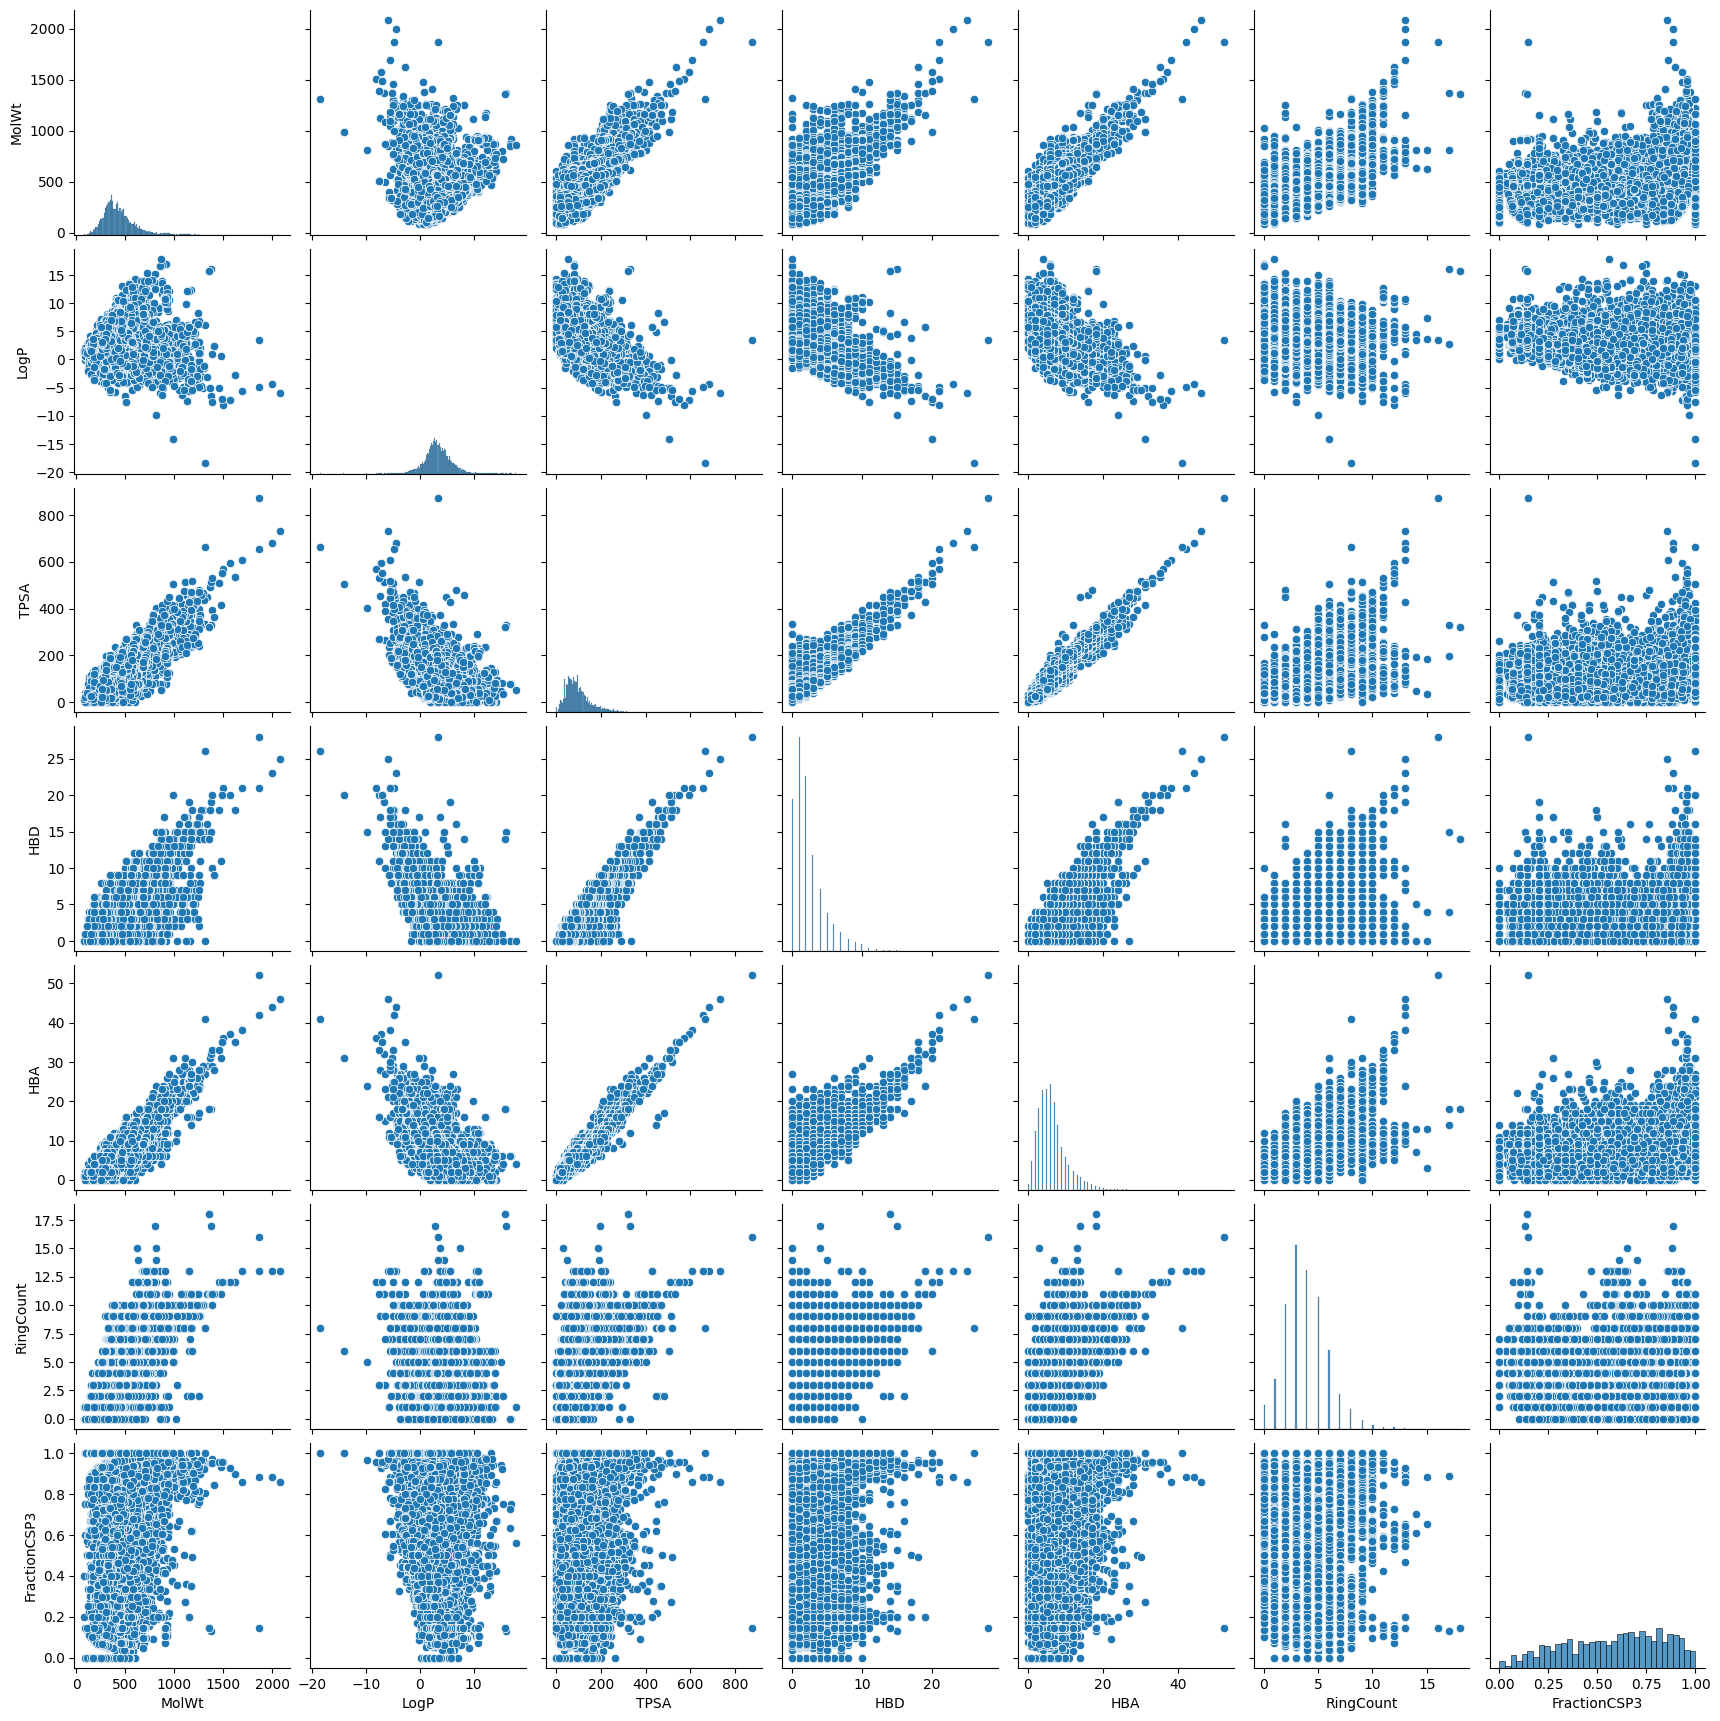

In [18]:
sns.pairplot(df_final)


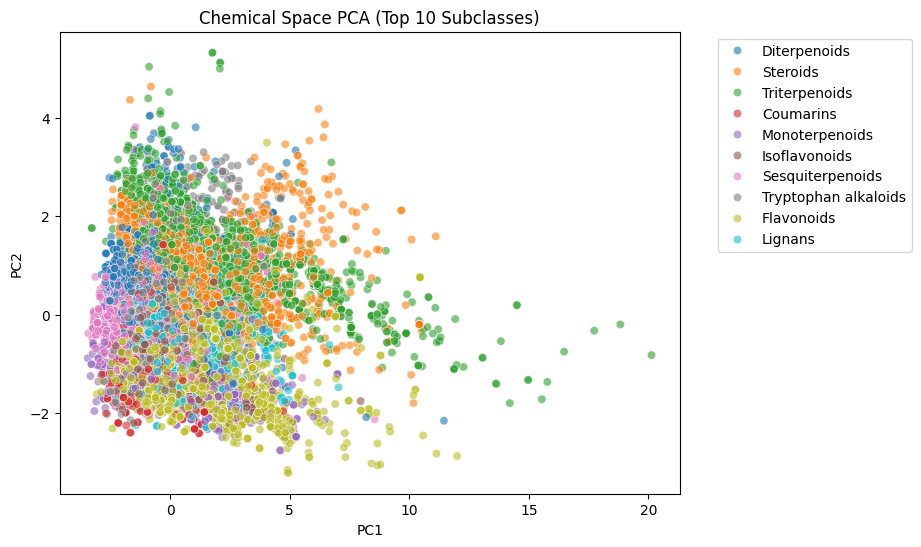

In [ ]:
# I pick top 10 most common subclasses 
# i didn't select all bc too many and if I select on my own it may be biased
top_sub = df_final["subclass"].value_counts().index[:10]

df_top = df_final[df_final["subclass"].isin(top_sub)]

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_top,
    x="PC1", y="PC2",
    hue="subclass",
    alpha=0.6,
    palette="tab10"
)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Chemical Space PCA (Top 10 Subclasses)")
plt.show()


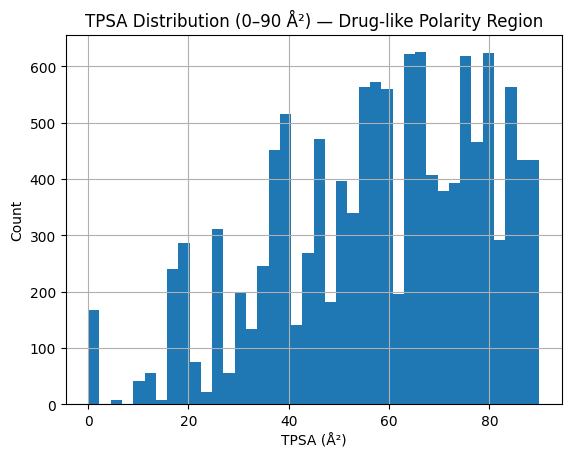

In [41]:
#TPSA = Topological Polar Surface Area a indicator of overall polarity.
#Most medicinal chemistry papers visualize TPSA in the 0–90 Å² region.
#TPSA < 90 Å² is the “sweet spot” for
# cell-membrane permeability
#  oral absorption
#  drug-likeness
df_tpsa = df_final[df_final["TPSA"] <= 90]

df_tpsa["TPSA"].hist(bins=40)
plt.xlabel("TPSA (Å²)")
plt.ylabel("Count")
plt.title("TPSA Distribution (0–90 Å²) — Drug-like Polarity Region",loc="center")
plt.show()


